In [1]:
# %% Import packages
import os
import numpy as np
import glob
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import sklearn.metrics as metrics
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [5]:
def remove_outlier(df):
    # traverse each column, if the z-score is greater than 3, remove the row
    for col in df.columns:
        if col != 'class':
            z_score = abs((df[col] - df[col].mean()) / df[col].std())
            df = df.iloc[np.where(z_score < 3)[0],:]
    return df

def load_data(id_paths, ood_paths):
    # append class attribute
    id_csv_list, ood_csv_list = [], []
    for id_path in id_paths:
        id_csv = pd.read_csv(os.path.join(id_path, 'RMSE_fit3_alt.csv'))

        # remove outlier
        id_csv = remove_outlier(id_csv)

        id_csv['class'] = 0
        id_csv_list.append(id_csv)

    for ood_path in ood_paths:
        ood_csv = pd.read_csv(os.path.join(ood_path, 'RMSE_fit3_alt.csv'))

        # remove outlier
        ood_csv = remove_outlier(ood_csv)

        ood_csv['class'] = 1
        ood_csv_list.append(ood_csv)
    
    id_csv = pd.concat(id_csv_list, axis=0)
    ood_csv = pd.concat(ood_csv_list, axis=0)
    df = pd.concat([id_csv, ood_csv], axis=0)

    # df_rmse = df['rmse_list']
    # print(df_rmse)

    df = df.drop(['rmse_list'], axis=1)  # e0 is the ground truth
    # prepare X and Y
    # Use all the other columns as features
    X = df["xrmse_list"]    # Baseline comparison: only use rmse_list as feature   
    Y = df['class']
    # split dataset
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=10)
    return X_train, X_valid, Y_train, Y_valid

In [6]:
def draw_roc_curve(X_valid, Y_valid, model):
    # predict probabilities
    probs = model.predict_proba(X_valid)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(Y_valid, probs)
    print('AUC: %.5f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = metrics.roc_curve(Y_valid, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, 'g', label = 'xg_best AUC = %0.5f' %auc)
    # Title 
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [7]:
# This function plots the precision-recall curve 
def draw_pr_curve(X_valid, Y_valid, model):
    # predict probabilities
    probs = model.predict_proba(X_valid)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(Y_valid, probs)
    # calculate F1 score
    f1 = f1_score(Y_valid, model.predict(X_valid))
    # calculate precision-recall AUC
    auc = metrics.auc(recall, precision)
    # calculate average precision score
    ap = metrics.average_precision_score(Y_valid, probs)
    print('f1=%.5f auc=%.5f ap=%.5f' % (f1, auc, ap))
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    # Title 
    plt.title('PR Plot')
    # Axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
AUC: 0.99143


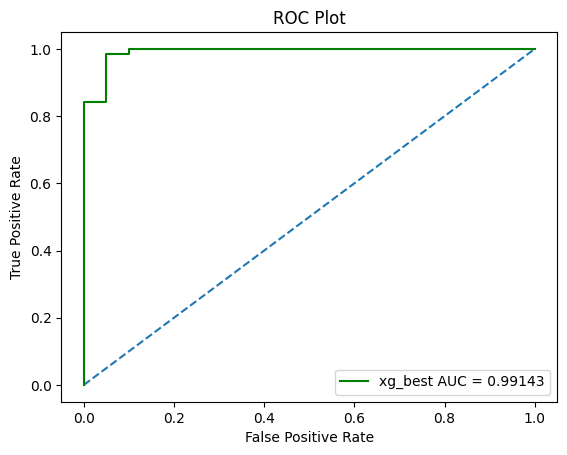

f1=0.98571 auc=0.99740 ap=0.99742


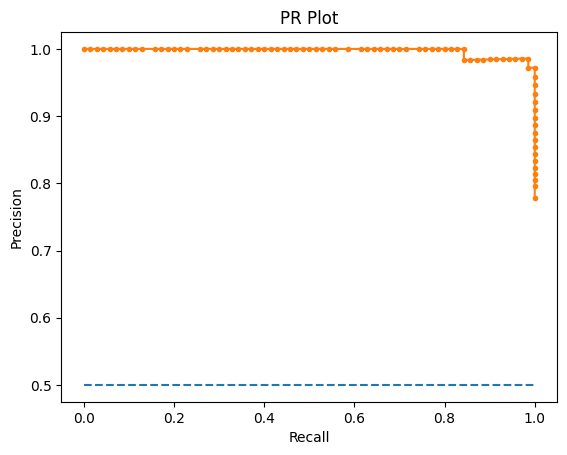

ValueError: training data did not have the following fields: rmse_fit_list, xrmse_fit_list, xrmse_list

In [10]:
# %% Load training data
models = ['anime', 'micro', 'face']
testsets = ['anime', 'micro', 'face']
wk_path = r'C:\Jacky\datasets'
THRES = [0.38, 0.12, 0.1]
# THRES = [0.22, 0.3, 0.25]

acc_matrix = np.zeros((len(models), len(testsets)))

for i, m in enumerate(models):
    ID_PATHS = [os.path.join(wk_path, '%s_dataset'%m, '%s_cycle'%m)]
    OOD_PATHS = [os.path.join(wk_path, '%s_dataset'%m, 'noised_1'),
    os.path.join(wk_path, '%s_dataset'%m, 'noised_2'),
    os.path.join(wk_path, '%s_dataset'%m, 'noised_3'),
    os.path.join(wk_path, '%s_dataset'%m, 'noised_4'),]

    X_train, X_valid, Y_train, Y_valid = load_data(ID_PATHS, OOD_PATHS)

    # %% Search for optimal hyperparameters
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    # define the grid search parameters for XGBoost
    param_grid_xg = {
        'n_estimators': [10, 30, 60, 90],
        'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.1],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.5],
        'subsample': [0.6, 0.9],
        'colsample_bytree': [0.6,  0.9],
        'reg_alpha': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [1, 1.5, 2.0]
    }
    # find the optimal parameters for XGBoost
    xg = XGBClassifier()
    xg_random = GridSearchCV(estimator = xg, param_grid = param_grid_xg,  cv = 5, verbose=2, n_jobs = -1)
    xg_random.fit(X_train, Y_train)
    xg_best = xg_random.best_estimator_
    draw_roc_curve(X_valid, Y_valid, xg_best)
    draw_pr_curve(X_valid, Y_valid, xg_best)
    

    
    for j, n in enumerate(testsets):
        if i == j:
            X0_valid, Y0_valid = X_valid[Y_valid == 0], Y_valid[Y_valid == 0]
            y_prob = xg_best.predict_proba(X0_valid)[:,1]
            y_pred = (y_prob >= THRES[i]).astype(int)
            acc = accuracy_score(Y0_valid, y_pred)
        else:
            # %% Load testing data
            ood_test_path = os.path.join(wk_path, '%s_dataset'%n, '%s_cycle'%m)
            ood_test_csv = pd.read_csv(os.path.join(ood_test_path, 'RMSE_fit3_alt.csv'))
            ood_test_csv['class'] = 1
            X_test = ood_test_csv["xrmse_list"]
            Y_test = ood_test_csv['class']

            y_prob = xg_best.predict_proba(X_test)[:,1]
            y_pred = (y_prob >= THRES[i]).astype(int)

            acc = accuracy_score(Y_test, y_pred)
            
        acc_matrix[i,j] = acc
    




In [68]:
acc_matrix 

array([[1.        , 0.        , 0.        ],
       [0.12244898, 0.8125    , 0.03370787],
       [0.5952381 , 0.11290323, 1.        ]])

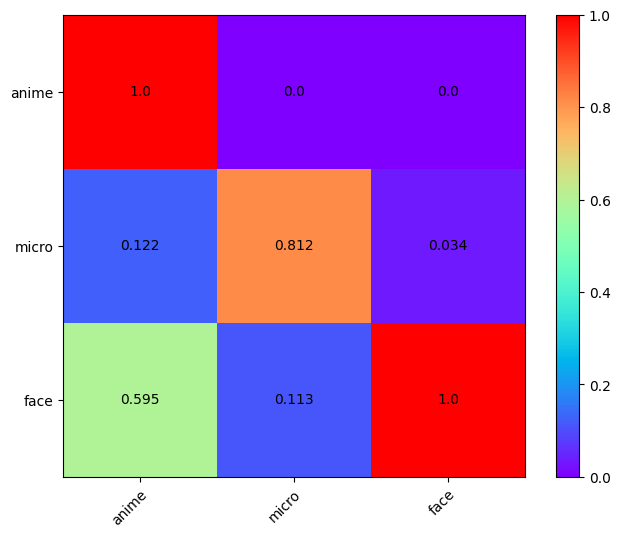

In [69]:
fig_heat = plt.figure(figsize=(8, 6))
ax_heat = fig_heat.add_subplot(111)


im_heat = ax_heat.imshow(acc_matrix, cmap="rainbow", interpolation='nearest')

# Show all ticks and label them with the respective list entries
ax_heat.set_xticks(np.arange(len(testsets)), labels=testsets)
ax_heat.set_yticks(np.arange(len(models)), labels=models)

# Rotate the tick labels and set their alignment.
plt.setp(ax_heat.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(models)):
    for j in range(len(testsets)):
        acc = round(acc_matrix[i, j], 3)
        # if i == j:
        #     acc = 1.00
                
        text = ax_heat.text(j, i, acc,
                       ha="center", va="center", color="black")

plt.colorbar(im_heat)
fig_heat.savefig(r'C:\Jacky\heatmap.png', dpi=100, bbox_inches='tight')

C:\Users\ozlab\AppData\Local\Temp\ipykernel_13240\380922950.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reverse_rainbow = plt.cm.get_cmap('rainbow', 256).reversed()


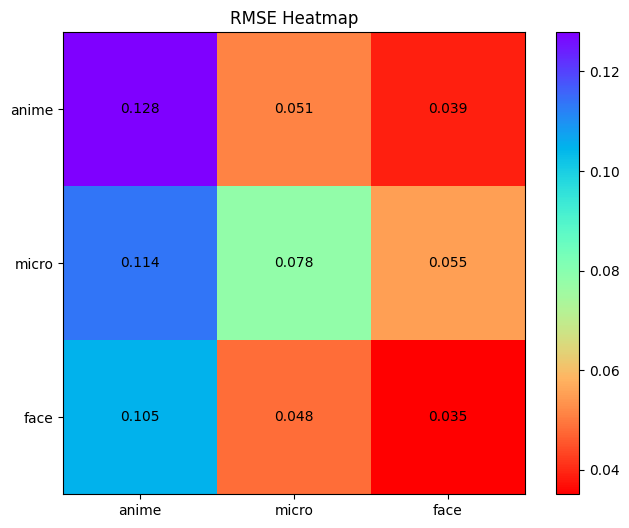

In [ ]:
rmse_matrix = np.zeros((len(models), len(testsets)))

for i, m in enumerate(models):
    for j, n in enumerate(testsets):
        if i == j:
            id_test_path = os.path.join(wk_path, '%s_dataset'%n, '%s_cycle'%m)
            id_test_csv = pd.read_csv(os.path.join(id_test_path, 'RMSE_fit3_alt.csv'))

            rmse_matrix[i,j] = np.mean(id_test_csv['rmse_list'])
        else:
            # %% Load testing data
            ood_test_path = os.path.join(wk_path, '%s_dataset'%n, '%s_cycle'%m)
            ood_test_csv = pd.read_csv(os.path.join(ood_test_path, 'RMSE_fit3_alt.csv'))

            rmse_matrix[i,j] = np.mean(ood_test_csv['rmse_list'])

fig_rmse = plt.figure(figsize=(8, 6))
ax_rmse = fig_rmse.add_subplot(111)

ax_rmse.set_title('RMSE Heatmap')
reverse_rainbow = plt.cm.get_cmap('rainbow', 256).reversed()
im = ax_rmse.imshow(rmse_matrix, cmap=reverse_rainbow, interpolation='nearest')

# Show all ticks and label them with the respective list entries
ax_rmse.set_xticks(np.arange(len(testsets)), labels=testsets)
ax_rmse.set_yticks(np.arange(len(models)), labels=models)

# Rotate the tick labels and set their alignment.
plt.setp(ax_heat.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(models)):
    for j in range(len(testsets)):
        rmse = round(rmse_matrix[i, j], 3)
        # if i == j:
        #     rmse = 0.00
                
        text = ax_rmse.text(j, i, rmse,
                       ha="center", va="center", color="black")

plt.colorbar(im)